## <h1><center>Introduction and Schema Diagram</center></h1>

In this guided project, we're going to practice using our SQL skills to answer business questions. In each step, we'll give you a task, and you'll need to:

* Write a SQL query to extract the relevant data
* Create plots where necessary to visualize the data
* Write a short paragraph, drawing conclusions and explaining the data and/or visualizations.

We'll continue to use the Chinook database that we've used in earlier missions of this course. The Chinook database is provided as a SQLite database file called chinook.db. A copy of the database schema is below - you'll need to come back to this step often to consult the schema as you write your queries.

![alt text](table.jpg "Title")

It's worth remembering that our database retains 'state', so if we run a query with a **CREATE** or **DROP** twice, the query will fail. We should have the skills to get ourselves untangled from these situations, but if you have trouble, or if you manage to lock your database, we have provided a *chinook-unmodified.db* file that you can copy over the chinook.db to restore it back to its initial state (see <a href="https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/#17executingshellcommands"> this blog post </a>on how to run shell commands within a Jupyter notebook).

Most of the queries you'll create in this guided project are more difficult than what you have written in the earlier missions in this course, and we'll provide you with less explicit guidance on how to answer each business question. Don't be discouraged if working on these queries takes several iterations.

We have provided a solution notebook (accessible via the icon at the top of the interface), however we recommend only consulting this as a last resort, or when you have finished and would like to see how we went about the step. Also keep in mind that there are often several 'correct' ways to write these queries, and that our solution notebook shows just one of these.

Here are a few tips to keep in mind while working on these queries:

* Write your query in stages, and run it as you go to make sure at each stage it's producing the output you expect.
* If something isn't behaving as you expect, break parts of the query out into their own, separate queries to make sure there's not an inner logic error.
* Don't be afraid to write separate queries to check the underlying data, for instance you might write a query that you can use to manually check a calculation and give yourself confidence that the output you're seeing is correct.


## <h1><center>Creating Helper Functions</center></h1>

In the SQL fundamentals course we learned how to use python's <a href="https://docs.python.org/3/library/sqlite3.html"> SQLite module</a> and pandas to write queries that produced dataframe outputs. The advantage of dataframe outputs is that they will display as tables in Jupyter notebook. We can also take advantage of pandas plotting methods to easily create visualizations of our tables inside our Jupyter notebook.

If you aren't familiar with pandas plotting methods, we recommend this guided project from our Data Visualization course, which teaches some of these methods. The <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html"> visualization section </a>of the pandas docs will be useful - we encourage you to have a look and see if you can use a few plot types that you might not have already used before.

Previously, we used the *sqlite3.connect()* function to create a connection object, and passed that to the *pandas.read_sql_query()* function. In this project, we'll use a similar approach, with two important changes:

* We'll create some helper functions in python to save some time.
* We'll use a context manager to handle the connection to the SQLite database.

Context managers make our life easy by taking care of opening and closing the connection to the database, as well as making sure we don't accidentally make changes to the database if one of our queries has an error. If you're interested in learning more about context managers, we recommend this <a href="https://jeffknupp.com/blog/2016/03/07/python-with-context-managers/"> excellent article</a> by Jeff Knupp. For now, all we need to know is that we'll use the with statement to access the <a href="https://docs.python.org/3/library/sqlite3.html#using-the-connection-as-a-context-manager">context manager that's built-in to the SQLite module</a>:

With a few extra lines, we can turn this code into a function:

In [12]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

By returning the dataframe, we can just run our function as the last line of a Jupyter cell and it will print the results nicely for us.

We'll also create a function to run SQL queries that don't return tables, like CREATE VIEW. In this instance, we don't need to use pandas, we can simply use the SQLite module's *connection.execute()* method:

The **conn.isolation_level = None** line above tells SQLite to autocommit any changes - we'll talk more about that in the next mission.

Lastly, we'll make a function that uses our **run_query()** function to return a list of all tables and views in our databases - this is handy to quickly check the state of our database as we work. To make this easier, the query you'll need to use in this function is below:

#### Exercise

1. Import the SQLite, pandas and matplotlib modules, and use the magic command %matplotlib inline to make sure any plots render in the notebook.
2. Create a run_query() function, that takes a SQL query as an argument and returns a pandas dataframe of that query.
3. Create a run_command() function that takes a SQL command as an argument and executes it using the sqlite module.
4. Create a show_tables() function that calls the run_query() function to return a list of all tables and views in the database.
5. Run the show_tables() function.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

In [14]:
db = 'chinook_original.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [20]:
query="""
SELECT * FROM GENRE
"""

run_query(query)

,genre_id,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll
5,6,Blues
6,7,Latin
7,8,Reggae
8,9,Pop
9,10,Soundtrack


## <h1><center>Selecting Albums to Purchase</center></h1>

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

![alt text](pur.jpg "Title")

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

**You'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas**.

You can run the ***run_query()*** function twice. Once at the end of a cell to display the results, and then a second time to assign the output of yours to a variable name:

You can then use the **DataFrame.plot()** method or any of the other pandas plotting methods to produce your visualization. You can choose the sort of plot you think best communicates the data, but if you're stuck, a bar plot or horizontal bar plot will work well.

Note that if you use the **DataFrame.set_index()** method before you create your plot, your axis labels will be automatically added to your plot as shown <a href="https://www.dataquest.io/blog/adding-axis-labels-to-plots-with-pandas-and-matplotlib/"> in this blogpost</a>.

Lastly, you should write up a summary of your findings, and make a recommendation for the three artists whose albums we should purchase for the store.

## Most popular genres at our Store

***In the next section I will write a query that returns each genre, with the number of tracks sold in the USA***:

* in absolute numbers
* in percentages

In [4]:
albums_to_purchase_2 ="""
WITH
     only_usa_invoices AS
        (
        SELECT 
            i.billing_country AS country,
            il.track_id AS track_id,
            il.quantity AS quantity
        FROM invoice_line AS il
        INNER JOIN invoice AS i ON il.invoice_id = i.invoice_id
        WHERE i.billing_country = "USA"
        ),
        tracks_with_invoices AS
        (
        SELECT
            only_usa.country AS country,
            only_usa.quantity AS quantity,
            only_usa.track_id AS track_id,
            tr.genre_id AS genre
        FROM only_usa_invoices AS only_usa
        INNER JOIN track AS tr ON only_usa.track_id = tr.track_id
        )
        
SELECT 
        g.name AS genre,
        SUM(trwi.quantity) AS tracks_sold,
        CAST(SUM(trwi.quantity) *100 AS float) / (SELECT COUNT(*) FROM only_usa_invoices) AS percentage_sold,  
        trwi.country AS country
FROM tracks_with_invoices AS trwi
INNER JOIN genre AS g ON trwi.genre = g.genre_id
GROUP BY 1 ORDER BY 2 DESC;
        

"""

run_query(albums_to_purchase_2)

,genre,tracks_sold,percentage_sold,country
0,Rock,561,53.377735,USA
1,Alternative & Punk,130,12.369172,USA
2,Metal,124,11.798287,USA
3,R&B/Soul,53,5.042816,USA
4,Blues,36,3.425309,USA
5,Alternative,35,3.330162,USA
6,Latin,22,2.093245,USA
7,Pop,22,2.093245,USA
8,Hip Hop/Rap,20,1.902950,USA
9,Jazz,14,1.332065,USA


In [6]:
genre_sales_usa = run_query(albums_to_purchase_2)

**Remove rows where sales do not reach 1% in the store, and sum up them in one single row, called Others**:

In [7]:
genre_sales_usa_majors = genre_sales_usa.copy()

genre_sales_usa_majors.loc[17] = ['Others', genre_sales_usa_majors.loc[11:16]['tracks_sold'].sum(), genre_sales_usa_majors.loc[11:16]['percentage_sold'].sum(), 'USA']

genre_sales_usa_majors = genre_sales_usa_majors.drop(genre_sales_usa_majors.index[11:17]) #drop the unnecessary rows

In [8]:
genre_sales_usa_majors.set_index('genre', inplace=True)
genre_sales_usa_majors

,tracks_sold,percentage_sold,country
genre,,,
Rock,561,53.377735,USA
Alternative & Punk,130,12.369172,USA
Metal,124,11.798287,USA
R&B/Soul,53,5.042816,USA
Blues,36,3.425309,USA
Alternative,35,3.330162,USA
Latin,22,2.093245,USA
Pop,22,2.093245,USA
Hip Hop/Rap,20,1.902950,USA


## Show the results in pie chart

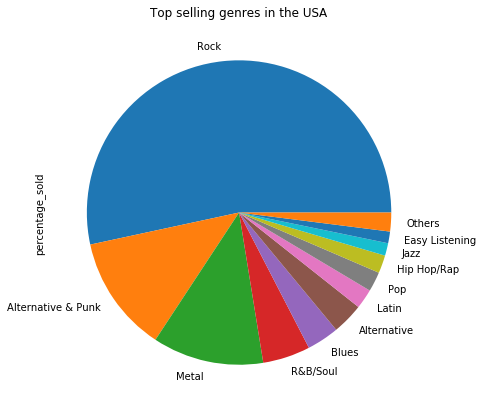

In [131]:
genre_sales_usa_majors['percentage_sold'].plot(kind='pie', figsize=(7,7), title='Top selling genres in the USA')

According to the sales record we should add these albums to our store:
* Red Tone - Punk
* Meteor and the Girls - Pop
* Slim Jim Bites - Blues

# <h1><center>Analyzing Employee Sales Performance</center></h1>

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

#### Instructions

1. Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.
2. Create a plot of the results of your query.


In [38]:
employee_performance ="""
WITH
     customer_purchase AS
        (
        SELECT 
            c.customer_id AS customer_id,
            c.support_rep_id,
            SUM(i.total) AS total_purchase
        FROM customer AS c
        INNER JOIN invoice AS i ON c.customer_id = i.customer_id
        GROUP BY 1
        )
      
SELECT 
       e.first_name || " " || e.last_name AS employee_name,
       e.hire_date AS hire_date,
       SUM(cp.total_purchase)
FROM 
employee AS e
INNER JOIN customer_purchase AS cp ON e.employee_id = cp.support_rep_id
GROUP BY 1;

"""

In [39]:
run_query(employee_performance)

,employee_name,hire_date,SUM(cp.total_purchase)
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


In [40]:
employee_sales = run_query(employee_performance)

employee_sales.set_index("employee_name", inplace=True)
employee_sales

,hire_date,SUM(cp.total_purchase)
employee_name,,
Jane Peacock,2017-04-01 00:00:00,1731.51
Margaret Park,2017-05-03 00:00:00,1584.00
Steve Johnson,2017-10-17 00:00:00,1393.92


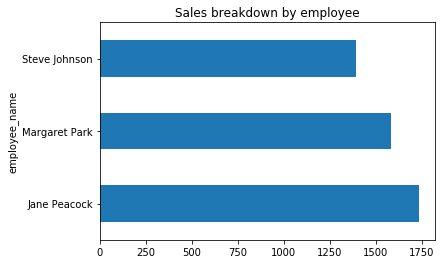

In [44]:
employee_sales.plot(kind='barh', title='Sales breakdown by employee', legend=False)



While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

# <h1><center>Analyzing Sales by Country</center></h1>

Your next task is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Because there are a number of countries with only one customer, you should group these customers as "Other" in your analysis. You can use the following 'trick' to force the ordering of "Other" to last in your analysis.

If there is a particular value that you would like to force to the top or bottom of results, you can put what would normally be your most outer query in a subquery with a case statement that adds a numeric column, and then in the outer query sort by that column. Here's an example - let's start by creating a view so we're working with a manageable number of rows:

In [22]:
c = '''
CREATE VIEW top_5_names AS
     SELECT
         first_name,
         count(customer_id) count
     FROM customer
     GROUP by 1
     ORDER by 2 DESC
     LIMIT 5;
'''
run_command(c)

q = 'SELECT * FROM top_5_names;'
run_query(q)

,first_name,count
0,Frank,2
1,Mark,2
2,Aaron,1
3,Alexandre,1
4,Astrid,1


Next, inside a subquery, we'll select all values from our view and add a sorting column using a case statement, before sorting using that new column in the outer query.

In [23]:
q = '''
SELECT
    first_name,
    count
FROM
    (
    SELECT
        t5.*,
        CASE
            WHEN t5.first_name = "Mark" THEN 1
            ELSE 0
        END AS sort
    FROM top_5_names t5
   )
ORDER BY sort ASC
'''
run_query(q)

,first_name,count
0,Frank,2
1,Aaron,1
2,Alexandre,1
3,Astrid,1
4,Mark,2


You should be able to adapt this technique into your query to force 'Other' to the bottom of your results. When working through this exercise, you will need multiple subqueries and joins. Imagine you work on a team of data analysts, and write your query so that it will be able to be easily read and understood by your colleagues.

In the next screen we'll create some visualizations and interpret the data - for now we'll just write our query.

#### Instructions

1. Write a query that collates data on purchases from different countries.
    * Where a country has only one customer, collect them into an "Other" group.
    * The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
    * For each country, include:
        * total number of customers
        * total value of sales
        * average value of sales per customer
        * average order value

In [34]:
countries_performance ="""
WITH
     sales AS
        (
        SELECT 
           il.unit_price * il.quantity AS one_orders_value,
           i.customer_id AS customer_id,
           SUM(i.total) AS total_purchase_per_customer,
           COUNT(distinct il.invoice_id) AS orders_number
        FROM invoice AS i
        INNER JOIN invoice_line AS il ON i.invoice_id = il.invoice_id
        GROUP BY 2
        ),
        customers_totals AS
        (
        SELECT 
            c.country AS country,
            SUM(total_purchase_per_customer) AS total_sales_of_country,
            SUM(s.customer_id) AS total_customer_number,
            SUM(s.one_orders_value) AS summa_order,
            s.orders_number AS orders_number
        FROM sales AS s
        INNER JOIN customer AS c ON s.customer_id = c.customer_id
        GROUP BY 1
        )
SELECT
    ct.country,
    ct.total_sales_of_country,
    ct.total_customer_number,
    (ct.total_sales_of_country) / (ct.total_customer_number) AS avg_sales_per_customer,
    (ct.summa_order) / ct.orders_number  AS avg_order_value
FROM customers_totals AS ct
ORDER BY 2 DESC;
    
        
        
        
      


"""

In [35]:
run_query(countries_performance)

,country,total_sales_of_country,total_customer_number,avg_sales_per_customer,avg_order_value
0,USA,10405.89,286,36.384231,1.287000
1,Canada,5489.55,187,29.355882,0.660000
2,Brazil,4059.00,47,86.361702,0.330000
3,France,3972.87,205,19.379854,0.412500
4,Germany,3441.24,113,30.453451,0.440000
5,Czech Republic,3183.84,11,289.440000,0.165000
6,United Kingdom,2498.76,159,15.715472,0.330000
7,India,1887.93,117,16.136154,0.247500
8,Portugal,1755.27,69,25.438696,0.123750
9,Ireland,1433.52,46,31.163478,0.076154


# Visualizing Sales by Country

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

When we're working with data that has many dimensions, it can be tempting to try and communicate every dimension in a single plot. This often results in complex and hard to read visualizations. Instead of this, we should create different plots for each dimension.

Think about the best way to communicate the data - this includes not only plot types, but how you use color, spacing and layout. As an example, you might decide to use the same color across your four plots to represent each country, so it's easier to understand the chart as a whole.

#### Instructions

1. For each dimension, create a visualization which demonstrates the data we collated in the previous step.
    * You should decide whether the "Other" group is relevant to your analysis and make decisions on where to include it (if anywhere) in your visualizations.
2. Write a few sentences interpreting your data and visualizations, and make one or more recommendations to the marketing team on which countries have potential for growth.

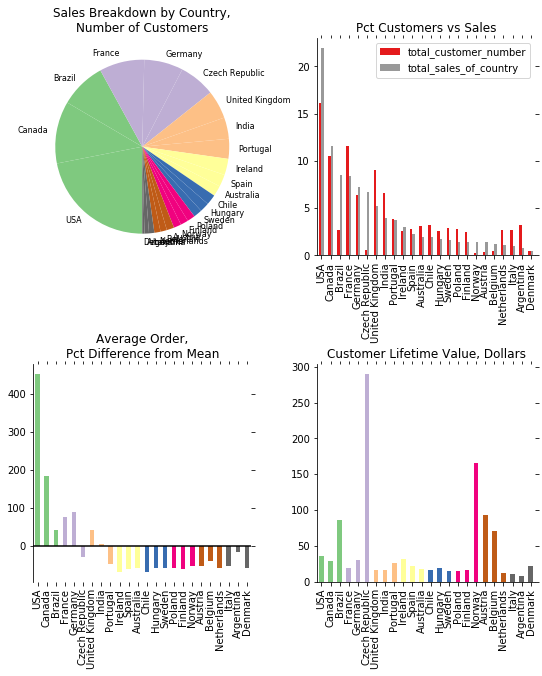

In [47]:
country_metrics = run_query(countries_performance)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales_of_country"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["total_customer_number","total_sales_of_country"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["avg_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100

difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["avg_sales_per_customer"].copy()
ltv.index.name = ''

ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

# <h1><center>Albums vs Individual Tracks</center></h1>

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

Up until now, we've only ever compared two single values, using operators like = != and LIKE. To compare two tables of value, we can use the EXCEPT operator that we learned in the previous mission.

Let's say we had three tables in a database, as shown in the diagram below

![alt text](tt.jpg "Title")

![alt text](tt2.jpg "Title")

![alt text](tt3.jpg "Title")

In [15]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.